<a href="https://colab.research.google.com/github/vivek-a81/EVA6/blob/main/Session8/session_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/MittalNeha/vision_pytorch.git

Cloning into 'vision_pytorch'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 23 (delta 6), reused 20 (delta 6), pack-reused 0
Unpacking objects: 100% (23/23), done.


In [2]:
!pip install --upgrade albumentations

     |████████████████████████████████| 102kB 6.3MB/s 
     |████████████████████████████████| 38.2MB 75kB/s 
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [3]:
import numpy as np
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch 
from torchvision import datasets, transforms
from torchsummary import summary

from vision_pytorch.models import resnet
from vision_pytorch.main import *
from vision_pytorch.utils import *

In [4]:
from vision_pytorch.gradcam import GradCAM

In [5]:
import importlib
import vision_pytorch
importlib.reload(vision_pytorch.gradcam)
# importlib.reload(resnet)

<module 'vision_pytorch.gradcam' from '/content/vision_pytorch/gradcam.py'>

In [6]:
trainset, testset = download_data()


Extracting /content/data/cifar-10-python.tar.gz to /content/data
Files already downloaded and verified


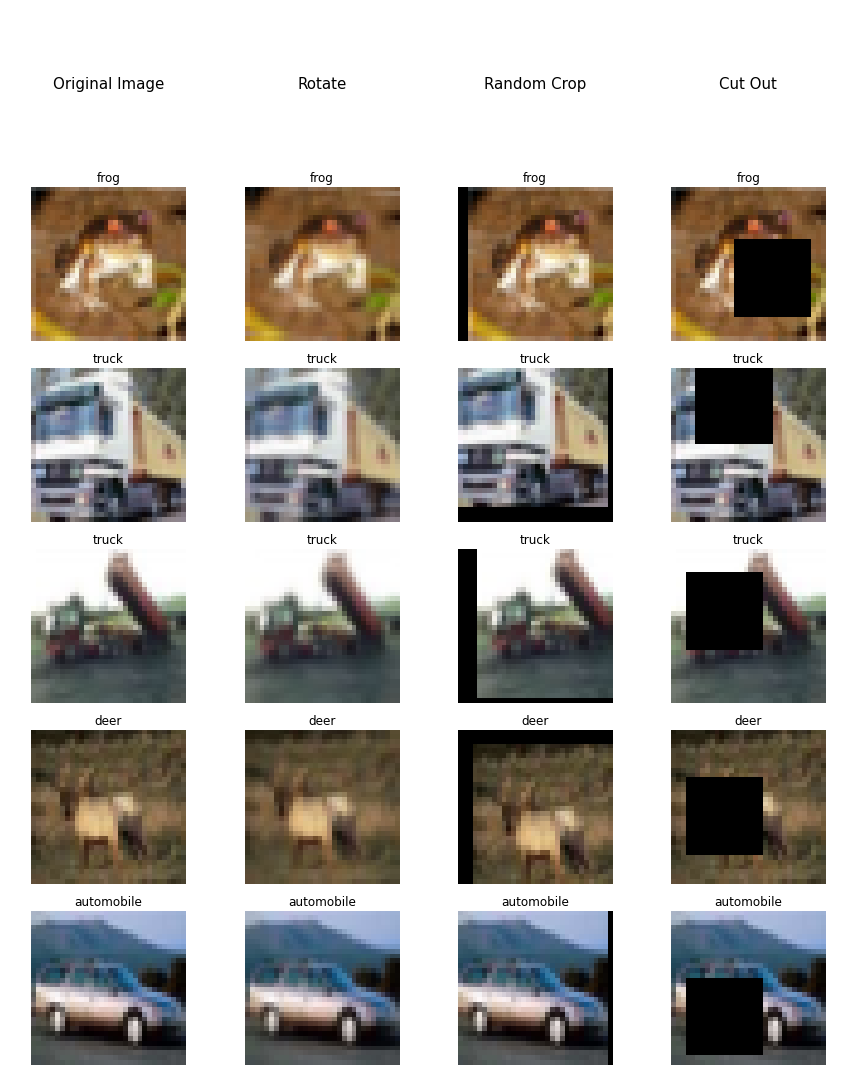

In [7]:
plot_aug({
    'Original Image': None,
    'Rotate': A.Rotate (limit=5, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=True, p=0.5),
    
    'Random Crop': A.Sequential([A.CropAndPad(px=4, keep_size=False), #padding of 2, keep_size=True by default
                A.RandomCrop(32,32)]),
    'Cut Out': A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, 
                               min_width=16, fill_value=0.473363, mask_fill_value=None, always_apply=True)
}, data=trainset)

In [8]:
# Apply these transforms while training:
# RandomCrop(32, padding=4)
# CutOut(16x16)
# Rotate(±5°)

train_transform = A.Compose({
  A.Rotate (limit=5, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
  A.Sequential([A.CropAndPad(px=4, keep_size=False), #padding of 2, keep_size=True by default
                A.RandomCrop(32,32)]),
  A.CoarseDropout(1, 16, 16, 1, 16, 16,fill_value=0.473363, mask_fill_value=None),
  A.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)),
})

test_transform = A.Compose({
  A.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))
})

In [9]:
cuda = torch.cuda.is_available()
print("CUDA Available:", cuda)
SEED = 1
# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    BATCH_SIZE=64
else:
    BATCH_SIZE=32

CUDA Available: True


In [10]:
train_loader = torch.utils.data.DataLoader(LoadDataset(trainset, train_transform), batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(LoadDataset(testset, test_transform), batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=1)

In [11]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [12]:
net_18 = resnet.ResNet18().to(device)
summary(net_18, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
         GroupNorm-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
         GroupNorm-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
         GroupNorm-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
         GroupNorm-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
        GroupNorm-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
        GroupNorm-14          [-1, 128,

In [13]:
optimizer = torch.optim.SGD(net_18.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,mode='min', patience=8, verbose=True)

net_18, history_18 = fit_model(
    net=net_18,
    train_loader=train_loader, test_loader=test_loader,
    scheduler=scheduler, 
    optimizer=optimizer, device=device, NUM_EPOCHS=40
)

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 1


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.9414, Accuracy: 2501/10000 (25.01%)

EPOCH: 2


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.7996, Accuracy: 3614/10000 (36.14%)

EPOCH: 3


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.5864, Accuracy: 4249/10000 (42.49%)

EPOCH: 4


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.4096, Accuracy: 4840/10000 (48.40%)

EPOCH: 5


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.2807, Accuracy: 5343/10000 (53.43%)

EPOCH: 6


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.3369, Accuracy: 5438/10000 (54.38%)

EPOCH: 7


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1665, Accuracy: 5748/10000 (57.48%)

EPOCH: 8


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0982, Accuracy: 6089/10000 (60.89%)

EPOCH: 9


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9233, Accuracy: 6750/10000 (67.50%)

EPOCH: 10


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8930, Accuracy: 6870/10000 (68.70%)

EPOCH: 11


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8452, Accuracy: 7020/10000 (70.20%)

EPOCH: 12


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9882, Accuracy: 6591/10000 (65.91%)

EPOCH: 13


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7545, Accuracy: 7315/10000 (73.15%)

EPOCH: 14


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7184, Accuracy: 7493/10000 (74.93%)

EPOCH: 15


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7865, Accuracy: 7298/10000 (72.98%)

EPOCH: 16


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6055, Accuracy: 7928/10000 (79.28%)

EPOCH: 17


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7315, Accuracy: 7523/10000 (75.23%)

EPOCH: 18


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5600, Accuracy: 8053/10000 (80.53%)

EPOCH: 19


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5512, Accuracy: 8080/10000 (80.80%)

EPOCH: 20


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5413, Accuracy: 8157/10000 (81.57%)

EPOCH: 21


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5159, Accuracy: 8237/10000 (82.37%)

EPOCH: 22


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5005, Accuracy: 8302/10000 (83.02%)

EPOCH: 23


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5692, Accuracy: 8091/10000 (80.91%)

EPOCH: 24


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4665, Accuracy: 8421/10000 (84.21%)

EPOCH: 25


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5741, Accuracy: 8118/10000 (81.18%)

EPOCH: 26


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4503, Accuracy: 8455/10000 (84.55%)

EPOCH: 27


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5172, Accuracy: 8272/10000 (82.72%)

EPOCH: 28


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4240, Accuracy: 8535/10000 (85.35%)

EPOCH: 29


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4748, Accuracy: 8468/10000 (84.68%)

EPOCH: 30


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4348, Accuracy: 8574/10000 (85.74%)

EPOCH: 31


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4034, Accuracy: 8639/10000 (86.39%)

EPOCH: 32


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4945, Accuracy: 8434/10000 (84.34%)

EPOCH: 33


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4104, Accuracy: 8656/10000 (86.56%)

EPOCH: 34


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4068, Accuracy: 8643/10000 (86.43%)

EPOCH: 35


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3827, Accuracy: 8722/10000 (87.22%)

EPOCH: 36


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3700, Accuracy: 8762/10000 (87.62%)

EPOCH: 37


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4277, Accuracy: 8632/10000 (86.32%)

EPOCH: 38


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3816, Accuracy: 8741/10000 (87.41%)

EPOCH: 39


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3889, Accuracy: 8770/10000 (87.70%)

EPOCH: 40


Batch_id=781 Loss=0.34745 Accuracy=87.74: 100%|██████████| 782/782 [01:11<00:00, 10.90it/s]



Test set: Average loss: 0.3717, Accuracy: 8801/10000 (88.01%)



In [15]:
torch.save(net_18.state_dict(), "resnet18.pt")

Plot the accuracy and loss curves

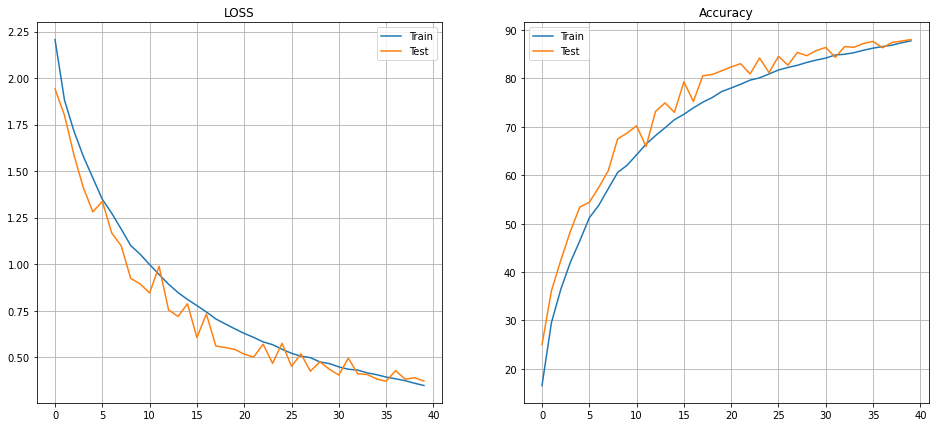

In [16]:
fig, axs = plt.subplots(1,2,figsize=(16,7))
axs[0].set_title('LOSS')
axs[0].plot(history_18[1], label='Train')
axs[0].plot(history_18[3], label='Test')
axs[0].legend()
axs[0].grid()

axs[1].set_title('Accuracy')
axs[1].plot(history_18[0], label='Train')
axs[1].plot(history_18[2], label='Test')
axs[1].legend()
axs[1].grid()

plt.show()

Load the saved model

In [ ]:
net_18.load_state_dict(torch.load("resnet18.pt"))

In [ ]:
summary(net_18,input_size = (3,32,32))

In [17]:
net_18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): GroupNorm(1, 64, eps=1e-05, affine=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): GroupNorm(1, 64, eps=1e-05, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): GroupNorm(1, 64, eps=1e-05, affine=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): GroupNorm(1, 64, eps=1e-05, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): GroupNorm(1, 64, eps=1e-05, affine=True)
      (shortcut): Sequential()
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


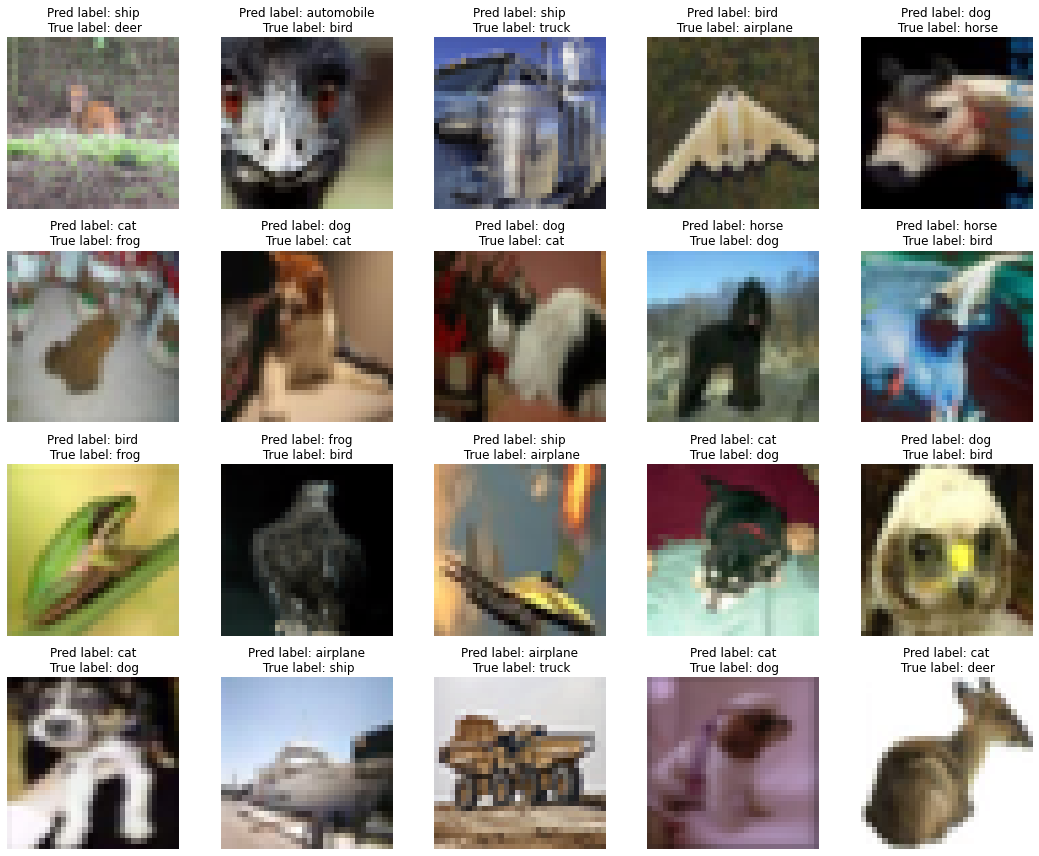

In [18]:
mean, std = np.array([0.49139968, 0.48215841, 0.44653091]), np.array([0.24703223, 0.24348513, 0.26158784])
images, labels = plot_misclassified(net_18, test_loader, testset.classes, device, mean, std, return_misclf=True)

#Load the model


In [ ]:
# net_18 = resnet.ResNet18().to(device)
# summary(net_18, input_size=(3, 32, 32))

In [ ]:
# net_18.load_state_dict(torch.load("resnet18.pt"))

# Understanding Gradcam

In [19]:
normalize = transforms.Normalize(mean, std)
n_image = []
for image in images:
    n_image.append(normalize(image))

In [20]:
inputs = torch.stack(images, dim=0)  #raw input
n_inputs = torch.stack(n_image, dim=0) #normalized input
target = torch.tensor(labels)

In [21]:
gcam = GradCAM(net_18.layer4[1])

In [22]:
loss_fn = nn.CrossEntropyLoss()

net_18 = net_18.cpu()
out = net_18(n_inputs)
print(out.size())
err = loss_fn(out, target)
err.backward()

BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): GroupNorm(1, 512, eps=1e-05, affine=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): GroupNorm(1, 512, eps=1e-05, affine=True)
  (shortcut): Sequential()
)
Inside GradCAM forward
torch.Size([20, 10])
Inside GradCAM backward


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [23]:
gcam.remove_hooks()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


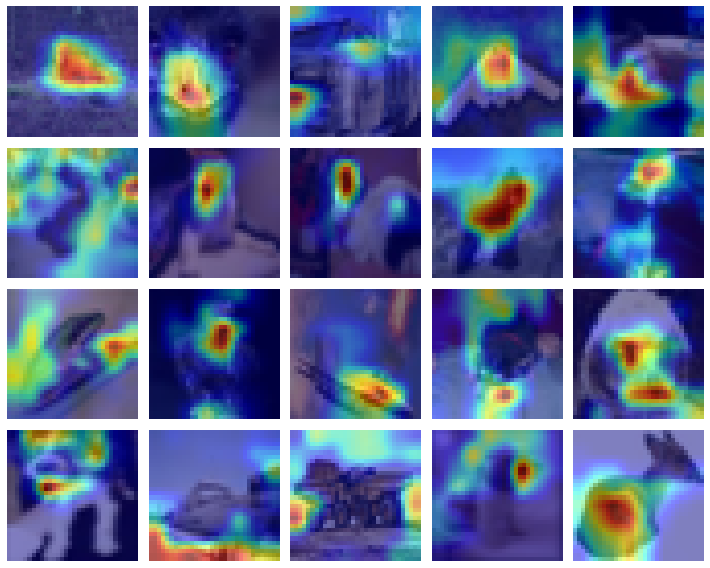

In [25]:
rows, cols = int(inputs.shape[0]/5),5
figure = plt.figure(figsize=(cols*2,rows*2))
for i in range(1, cols * rows + 1):
    # img, label, pred = misclf[i-1]

    figure.add_subplot(rows, cols, i) # adding sub plot
    # plt.title(f"Pred label: {classes[pred]}\n True label: {classes[label]}") # title of plot
    plt.axis("off") # hiding the axis
    img = gcam.generate(inputs, inputs.shape[2:], i-1)
    plt.imshow(img.squeeze(), cmap="rainbow") # showing the plot

plt.tight_layout()
plt.show()